In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist

In [2]:
test = pd.read_csv("test (1).csv")
train = pd.read_csv("train (1).csv")

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Q,S,1,2,3,4,5,6
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,A/5 21171,7.2500,NaN,0,1,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,PC 17599,71.2833,C85,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,113803,53.1000,C123,0,1,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,373450,8.0500,NaN,0,1,0,0,0,0,0,0


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
# turn sex into boolean
train['Sex'] = train['Sex'].apply({'male':0, 'female':1}.get)
test['Sex'] = test['Sex'].apply({'male':0, 'female':1}.get)

In [6]:
# dummy variables for 'embarked'
train['Embarked'].unique()
df_dummy = pd.get_dummies(train['Embarked'])
df_dummy = df_dummy.drop(columns = 'C')
frames = [train, df_dummy]
train = pd.concat(frames, axis = 1)
train = train.drop(columns = 'Embarked')
train.head()

test['Embarked'].unique()
df_dummy = pd.get_dummies(test['Embarked'])
df_dummy = df_dummy.drop(columns = 'C')
frames = [test, df_dummy]
test = pd.concat(frames, axis = 1)
test = test.drop(columns = 'Embarked')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Q,S
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,0,1


In [7]:
# dummy variables for 'Parch'

train['Parch'].unique()
df_dummy = pd.get_dummies(train['Parch'])
df_dummy = df_dummy.drop(columns = 0)
frames = [train, df_dummy]
train = pd.concat(frames, axis = 1)
train = train.drop(columns = 'Parch')
train.head()

test['Parch'].unique()
df_dummy = pd.get_dummies(test['Parch'])
df_dummy = df_dummy.drop(columns = 0)
frames = [test, df_dummy]
test = pd.concat(frames, axis = 1)
test = train.drop(columns = 'Parch')
test.head()

KeyError: "['Parch'] not found in axis"

In [9]:
train['Age'].unique()
avg_age = np.mean(train['Age'])
values = {'Age':avg_age}
train.fillna(value=values, inplace = True)
train.info()

avg_age = np.mean(test['Age'])
values = {'Age':avg_age}
test.fillna(value=values, inplace = True)
test.info()

avg_fare = np.mean(test['Fare'])
values = {'Fare':avg_fare}
test.fillna(value=values, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Q              891 non-null uint8
S              891 non-null uint8
1              891 non-null uint8
2              891 non-null uint8
3              891 non-null uint8
4              891 non-null uint8
5              891 non-null uint8
6              891 non-null uint8
dtypes: float64(2), int64(5), object(3), uint8(8)
memory usage: 76.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null ob

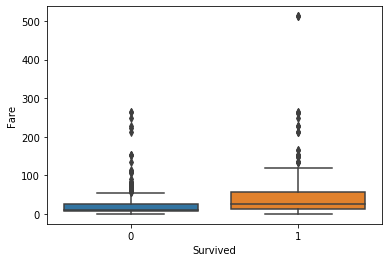

In [10]:
sns.boxplot(train['Survived'], train['Fare'])

In [11]:
# Features
features = list(train.columns)
features.remove('PassengerId')
features.remove('Survived')
features.remove('Name')
features.remove('SibSp')
features.remove('Ticket')
features.remove('Cabin')
features

['Pclass', 'Sex', 'Age', 'Fare', 'Q', 'S', 1, 2, 3, 4, 5, 6]

In [12]:
# logistic regression (initial model)
X = train.loc[:, features]
y = train.loc[:,'Survived']

X_test = test.loc[:, features]



lr = LogisticRegression()
lr.fit(X, y) 
predictions = lr.predict(X)
print(classification_report(y, predictions))
print('\n')
print(pd.crosstab(y, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True))

predictions_test = lr.predict(X_test)
df_pred = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predictions_test})
df_pred

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       549
           1       0.75      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.78       891
weighted avg       0.79      0.80      0.79       891



Predicted    0    1  All
Actual                  
0          469   80  549
1          102  240  342
All        571  320  891


/Users/KevinSun/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [13]:
avg_fare = np.mean(test['Fare'])
values = {'Fare':avg_fare}
test.fillna(value=values, inplace = True)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Q              418 non-null uint8
S              418 non-null uint8
1              418 non-null uint8
2              418 non-null uint8
3              418 non-null uint8
4              418 non-null uint8
5              418 non-null uint8
6              418 non-null uint8
9              418 non-null uint8
dtypes: float64(2), int64(5), object(3), uint8(9)
memory usage: 36.4+ KB


In [14]:
#csv files with predictions
titanic_lr = df_pred.to_csv('titanic_lr', index = False)

In [15]:
#decision tree
clf = DecisionTreeClassifier(criterion='entropy',max_depth = 4)
clf.fit(X,y)
predictions = clf.predict(X)
print(classification_report(y, predictions))
print('\n')
print(pd.crosstab(y, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True))

predictions_test = clf.predict(X_test)
df_pred2 = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':predictions_test})
titanic_dt = df_pred2.to_csv('titanic_dt', index = False)

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       549
           1       0.83      0.72      0.77       342

    accuracy                           0.84       891
   macro avg       0.83      0.81      0.82       891
weighted avg       0.83      0.84      0.83       891



Predicted    0    1  All
Actual                  
0          498   51  549
1           96  246  342
All        594  297  891


In [16]:
# random forests
forest = RandomForestClassifier(n_estimators = 100, max_depth = 5)
forest.fit(X,y)
forest.score(X,y)
forest_pred = forest.predict(X_test)
print(classification_report(y,forest.predict(X)))
df_pred3 = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':forest_pred})
titanic_rf = df_pred3.to_csv('titanic_rf', index = False)

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       549
           1       0.88      0.70      0.78       342

    accuracy                           0.85       891
   macro avg       0.86      0.82      0.83       891
weighted avg       0.85      0.85      0.84       891



In [17]:
forest2 = RandomForestClassifier(n_estimators = 100, max_depth = 10, max_features = 4)
forest2.fit(X,y)
forest2.score(X,y)
forest2_pred = forest2.predict(X_test)
df_pred4 = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':forest2_pred})
titanic_rf3 = df_pred4.to_csv('titanic_rf3', index = False)
forest2.score(X,y)

0.9382716049382716

In [18]:
#gradiant boost
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X,y)
gb.score(X,y)
gb_pred = gb.predict(X_test)
df_pred5 = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':gb_pred})
titanic_gb = df_pred5.to_csv('titanic_gb', index = False)
gb.score(X,y)

0.8832772166105499

In [19]:
#adaptive boost
ada_boost = AdaBoostClassifier(random_state=42)
ada_boost.fit(X,y)
ada_boost_pred = ada_boost.predict(X_test)
df_pred6 = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':gb_pred})
titanic_ada = df_pred6.to_csv('titanic_ada',index=False)
ada_boost.score(X,y)

0.8271604938271605

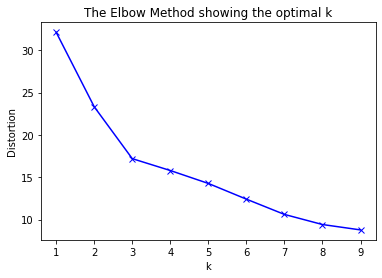

In [27]:

x = train[features]
#elbow plot for clustering
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(x)
    kmeanModel.fit(x)
    distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [28]:
#Clustering
kmeans_model = KMeans(n_clusters=3, random_state=1)
kmeans_model.fit(x)
train['cluster'] = kmeans_model.labels_ 

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Q,S,1,2,3,4,5,6,cluster
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,A/5 21171,7.2500,NaN,0,1,0,0,0,0,0,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,PC 17599,71.2833,C85,0,0,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,113803,53.1000,C123,0,1,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,373450,8.0500,NaN,0,1,0,0,0,0,0,0,2


In [35]:
train['cluster'].value_counts()

2    729
0    142
1     20
Name: cluster, dtype: int64